<h1> Predicting Whether Game Newsletter is Subscribed to Based on Age & Hours Played </h1>

<h3> Introduction </h3>

A research group in UBC Computer Science, led by Frank Wood, is collecting data on how people play video games by setting up a Minecraft server. Players' actions are collected through gameplay to analyze predictive factors for subscribing to a game-related newsletter; the lab also has other questions of interest, however, for this analysis, the focused question of interest will be explored.

This analysis asks if age and hours played can predict whether players are subscribed to the newsletter or not, using the `players.csv` dataset. 

This data is retrieved from Wood's research group. In this data, there are 196 players, each containing 7 different properties:

1. `experience`: The experience of the player (categorized from Beginner, Amateur, Regular, Pro, Veteran).
2. `subscribe`: Whether the player is subscribed to a game-related newsletter or not.
3. `hashedEmail`: The player's encrypted email.
4. `played_hours`: The total hours the player has contributed to the Minecraft server.
5. `name`: The player's first name.
6. `gender`: The player's gender.
7. `Age`: The age of the player.

<h3> Methods </h3>

This analysis will create a classification model for predicting the newsletter subscription (`TRUE/FALSE`) based on `Age` and `played_hours`. 

First, we load in the necessary packages to conduct our analysis.

In [67]:
library(tidyverse)
library(repr)
library(tidymodels)
options(repr.matrix.max.rows = 6)

The data `players.csv` was retrieved from Wood's research group. This is uploaded from the GitHub repository; we can read the data in from the data folder. We will also remove `hashedEmail` as it contains irrelevant data to our analysis.

In [68]:
players <- read_csv('data/players.csv') |>
    select(-hashedEmail)
head(players)

Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


experience,subscribe,played_hours,name,gender,Age
<chr>,<lgl>,<dbl>,<chr>,<chr>,<dbl>
Pro,TRUE,30.3,Morgan,Male,9
Veteran,TRUE,3.8,Christian,Male,17
Veteran,FALSE,0.0,Blake,Male,17
Amateur,TRUE,0.7,Flora,Female,21
Regular,TRUE,0.1,Kylie,Male,21
Amateur,TRUE,0.0,Adrian,Female,17


The data is in the right format for our analysis.

Because we are focusing on the age and hours played as a predictor for whether players subscribe to a newsletter or not, we will filter out all NA values and select only `subscribe`, `played_hours`, and `Age` as columns in our tidied dataframe. 

In [69]:
players_clean <- players |>
    select(subscribe, played_hours, Age) |>
    na.omit() |>
    mutate(subscribe = as.factor(subscribe))

head(players_clean)

subscribe,played_hours,Age
<fct>,<dbl>,<dbl>
TRUE,30.3,9
TRUE,3.8,17
FALSE,0.0,17
TRUE,0.7,21
TRUE,0.1,21
TRUE,0.0,17


Now that we have our cleaned data, we will create our classification model. First, we split the data to 75% training and 25% testing. We will then make the recipe.

In [70]:
set.seed(4)

players_split <- initial_split(players_clean, prop = 0.75, strata = subscribe)
players_training <- training(players_split)
players_testing <- testing(players_split)

players_recipe <- recipe(subscribe ~ . , players_training) |>
    step_center(all_predictors()) |>
    step_scale(all_predictors())

We need to find the most optimal `K`; we will perform a 5-fold cross-validation on the training set using `K = 1-10`. We will then plot the metrics.

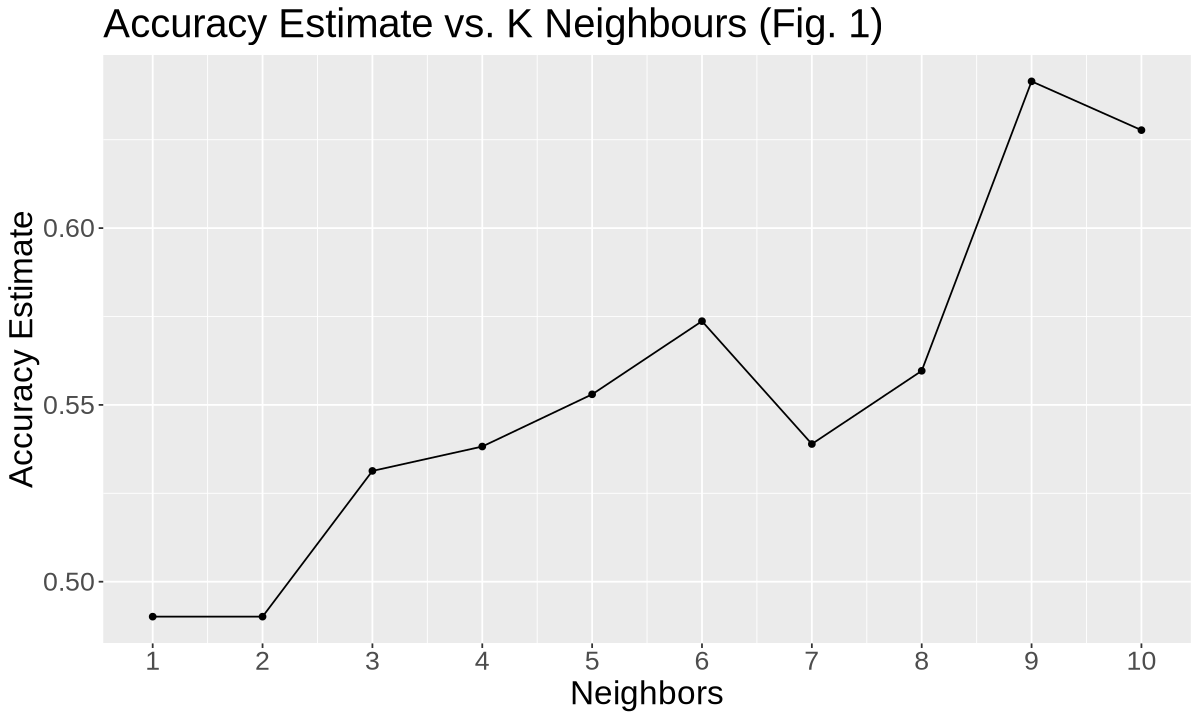

In [73]:
set.seed(4)

players_tune <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
            set_engine("kknn") |>
            set_mode("classification")

players_vfold <- vfold_cv(players_training, v = 5, strata = subscribe)

players_results <- workflow() |>
                 add_recipe(players_recipe) |>
                 add_model(players_tune) |>
                 tune_grid(resamples = players_vfold, grid = tibble(neighbors = c(1:10))) |>
                 collect_metrics()

accuracies <- players_results |>
                 filter(.metric == 'accuracy')

options(repr.plot.height = 6, repr.plot.width = 10)
cross_val_plot <- ggplot(accuracies, aes(x = neighbors, y = mean)) +
                  geom_point() +
                  geom_line() +
                  labs(x = 'Neighbors', y = 'Accuracy Estimate') +
                  theme(text = element_text(size = 20)) +
                  scale_x_continuous(breaks = seq(0, 10, 1)) +
                  ggtitle('Accuracy Estimate vs. K Neighbours (Fig. 1)')

cross_val_plot

From the plot above, we can see that `K = 9` has the highest accuracy estimate. We will create the model with `K = 9` and fit it through the workflow with the recipe.

In [74]:
set.seed(4)

players_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 9) |>
       set_engine("kknn") |>
       set_mode("classification")

players_fit <- workflow() |>
             add_recipe(players_recipe) |>
             add_model(players_spec) |>
            fit(data = players_training)
players_fit

══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
2 Recipe Steps

• step_center()
• step_scale()

── Model ───────────────────────────────────────────────────────────────────────

Call:
kknn::train.kknn(formula = ..y ~ ., data = data, ks = min_rows(9,     data, 5), kernel = ~"rectangular")

Type of response variable: nominal
Minimal misclassification: 0.4
Best kernel: rectangular
Best k: 9

We will now use the final model to predict on the test dataset. We will also report the accuracy of this prediction and the confusion matrix.

In [65]:
set.seed(4)

players_predictions <- predict(players_fit, players_testing) |>
                        bind_cols(players_testing)

players_metrics <- players_predictions |> metrics(truth = subscribe, estimate = .pred_class)

players_conf_mat <- players_predictions |>
                        conf_mat(truth = subscribe, estimate = .pred_class) 
players_metrics

players_conf_mat

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.6734694
kap,binary,0.2373541


          Truth
Prediction FALSE TRUE
     FALSE     7   10
     TRUE      6   26

We can see that we obtained an accuracy of 0.673. 

From the confusion matrix, we can obtain the recall and precision. In our case, our positive value will be `TRUE`.

In [66]:
recall <- 10/(10+26)
precision <- 10/(10+17)

recall
precision

[1] 0.2777778

[1] 0.3703704

We obtained a recall of 0.277 and a precision of 0.37.

<h3> Discussion </h3>

The classification model obtained results of accuracy = 0.673, recall = 0.277, and precision = 0.37. This model does not have high accuracy, and has low recall and precision. I would expect that more hours contributed to the game and that more adolescents would be more likely to subscribe to the newsletter, which would reflect in a stronger prediction and the accuracy being higher; however, from the results, it does not seem like there is a predictive factor from hours played and age.


Future questions can explore other predictive factors, such as the player's experience, perhaps gender, and other factors the research team decides to collect, such as the range of games the player plays other than Minecraft. Such findings can impact the study's ability to attract a certain demographic of participants, and help gaming industries better understand what players are attracted to from different demographics.

